In [1]:
import numpy as np, re, time
import funks as f
from typing import Any, Dict, List, Tuple
from Bio import Entrez, Medline
from decisiontree import DecisionTree

In [2]:
with open( 'positive_examples.txt' ) as file :
    posid = file.read().split( ',' )

In [3]:
with open( 'negative_examples.txt' ) as file :
    negid = file.read().split( ',' )

In [4]:
with open( 'stopset.txt' ) as file :
    stop_words = set( file.read().split( ',' ) )

In [5]:
def get_abstract( pmid : str ) -> str :
    '''
    Get Abstract from PubMed
    '''
    return Medline.read(
        Entrez.efetch(
            db = 'pubmed',
            id = pmid,
            email = 'chiodini.zachary@epa.gov',
            retmode = 'text',
            rettype = 'medline'
            )
        ).get( 'AB' )

In [6]:
# data structures
Count = int
Node = Any
Array = List
Class, Document, Word = str, str, str
Data = List[ Tuple[ Document, Class ] ]
Vocabulary = List[ Word ]
Tree = Dict[ Node, Dict ]

typing.Dict[typing.Any, typing.Dict]

In [7]:
# getting data
data : Data = np.ndarray( 
    shape = ( len( posid ) + len( negid ), 2 ), 
    dtype = object
    )
for i in range( len( posid ) ) :
    data[ i, 0 ] = get_abstract( posid[ i ] )
    data[ i, 1 ] = 'positive'
    time.sleep( 1/3 ) # avoid PubMed ban
for i in range( len( posid ), len( posid ) + len( negid ) ) :
    data[ i, 0 ] = get_abstract( negid[ i - len( posid ) ] )
    data[ i, 1 ] = 'negative'
    time.sleep( 1/3 ) # avoid PubMed ban

In [8]:
def extract( data : Data ) -> Vocabulary :
    '''
    Extract Vocabulary from Dataset
    '''
    vocabulary : Dict[ Word, Count ] = {}
    for document, label in data :
        for word in re.findall(
            pattern = '\\b[a-z]{2,}\\b',
            string  = document
            ) :
            if word not in stop_words :
                if word in vocabulary :
                    vocabulary[ word ] += 1
                else :
                    vocabulary[ word ] = 1
    # remove first quartile in vocabulary
    count = sorted( set( vocabulary.values() ) )
    index = len( count ) / 4
    if index % 1 == 0 :
        limit = count[ int( index ) ]
    else :
        index = int( index ) # truncate
        limit = ( count[ index ] + count[ index + 1 ] ) / 2
    for word, count in vocabulary.copy().items() :
        if count < limit :
            del vocabulary[ word ]
    return list( vocabulary )

In [9]:
features : Vocabulary = np.array( extract( data ) )

In [10]:
vector = np.vectorize( 
    lambda vocabulary, document : 
    int( vocabulary in document ) 
    )

In [154]:
X = np.array( [ vector( features, data[ i, 0 ] ) for i in range( len( data ) ) ] )
Y = data[ :, 1 ].reshape( len( X ), 1 )
R = np.hstack( ( X, Y ))

In [159]:
R

array([[1, 1, 1, ..., 0, 0, 'positive'],
       [0, 0, 0, ..., 0, 0, 'positive'],
       [1, 0, 0, ..., 0, 0, 'positive'],
       ...,
       [0, 0, 0, ..., 0, 0, 'negative'],
       [0, 0, 0, ..., 0, 0, 'negative'],
       [0, 0, 0, ..., 0, 0, 'negative']], dtype=object)

In [2]:
model = DecisionTree()
model.importcsv( 'data.txt' )

In [26]:
model.testAndTrain( ratio = 0 )

Samples in training set:  100
Samples tested         :  0
Total samples          :  100
Model accuracy         :  Unknown %


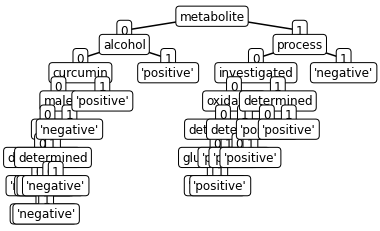

<Figure size 432x288 with 0 Axes>

In [27]:
model.plot()